## Imports and Setup

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
# Set plot style
sns.set(style="whitegrid")
%matplotlib inline

## Load Data and Basic Inspection

In [32]:
# Load the dataset
df = pd.read_csv('Manufacturing_ESG_Financial_Data.csv')

In [33]:
# Display basic info
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

Dataset Shape: (5000, 15)

First 5 rows:


,Firm_ID,Year,Industry_Type,ESG_Score,E_Score,S_Score,G_Score,ROA,ROE,Net_Profit_Margin,Revenue,Operating_Cost,Firm_Size,Board_Independence,Innovation_Spending
0,MFG0103,2023,Pharmaceuticals,64.746667,71.37,62.37,60.50,10.44,13.28,5.47,207.77,207.77,1543.50,81.08,3.97
1,MFG0436,2021,Automobile,78.060000,85.20,77.27,71.71,7.41,10.94,5.93,235.40,71.53,1593.30,64.35,5.51
2,MFG0349,2023,Textile,66.936667,75.20,59.36,66.25,6.54,17.87,9.63,226.76,226.76,1199.99,50.24,3.90
3,MFG0271,2021,Heavy Machinery,74.530000,100.79,71.56,51.24,9.85,14.60,10.41,432.06,240.16,1519.84,87.54,2.42
4,MFG0107,2019,Automobile,68.150000,55.59,74.07,74.79,5.34,11.51,12.63,164.27,164.27,920.14,67.48,5.05


In [34]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Firm_ID                0
Year                   0
Industry_Type          0
ESG_Score              0
E_Score                0
S_Score                0
G_Score                0
ROA                    0
ROE                    0
Net_Profit_Margin      0
Revenue                0
Operating_Cost         0
Firm_Size              0
Board_Independence     0
Innovation_Spending    0
dtype: int64


## Exploratory Data Analysis (Correlation)

In [35]:
# Calculate correlation matrix for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()

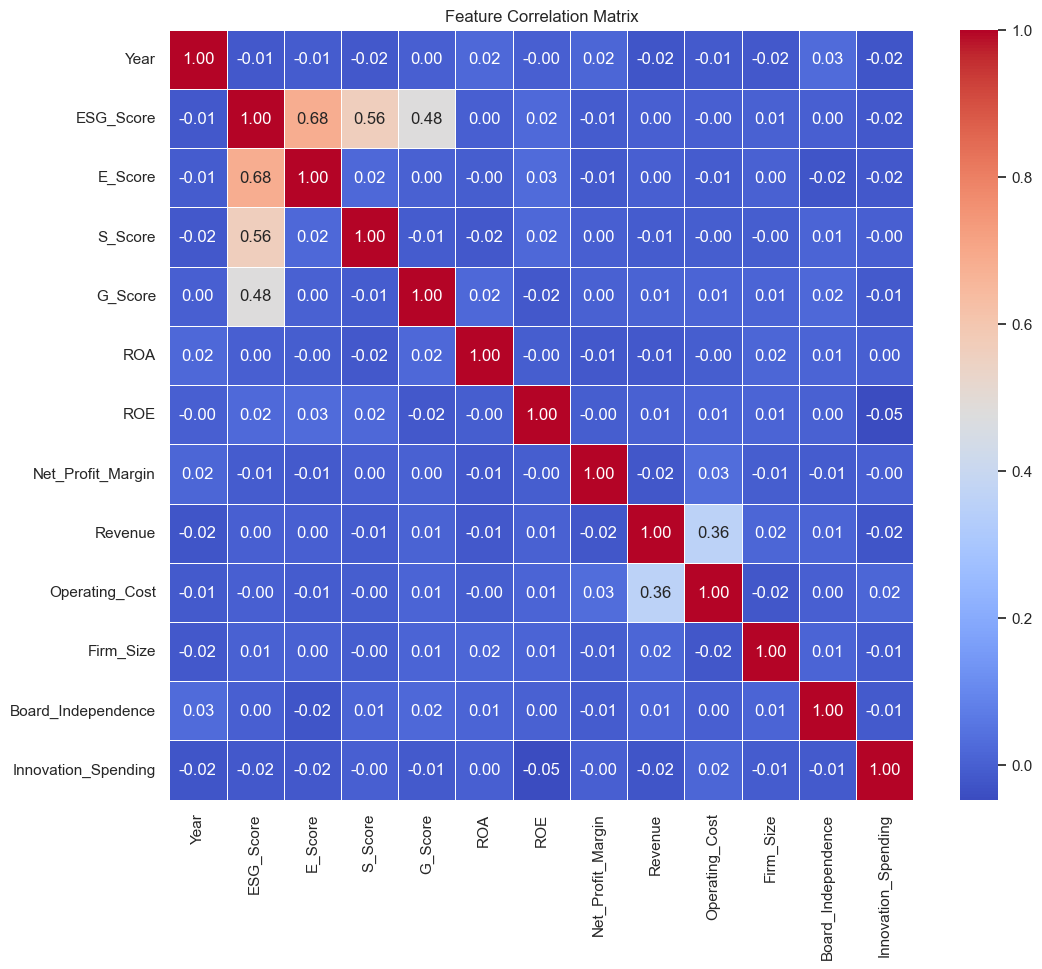

In [36]:
# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [37]:
# Show top correlations with E_Score
print("Top Correlations with E_Score:")
print(corr_matrix['E_Score'].sort_values(ascending=False))

Top Correlations with E_Score:
E_Score                1.000000
ESG_Score              0.683407
ROE                    0.030246
S_Score                0.018804
Firm_Size              0.004207
G_Score                0.003101
Revenue                0.000986
ROA                   -0.001977
Operating_Cost        -0.007184
Year                  -0.008548
Net_Profit_Margin     -0.011825
Innovation_Spending   -0.016561
Board_Independence    -0.022637
Name: E_Score, dtype: float64


## Feature Engineering & Data Verification

In [38]:
# Verify if ESG_Score is an average of E, S, and G
df['Calculated_Avg_ESG'] = (df['E_Score'] + df['S_Score'] + df['G_Score']) / 3
df['Diff'] = df['ESG_Score'] - df['Calculated_Avg_ESG']

In [39]:
print("Max deviation between ESG_Score and average(E,S,G):")
print(df['Diff'].abs().max())

Max deviation between ESG_Score and average(E,S,G):
7.105427357601002e-15


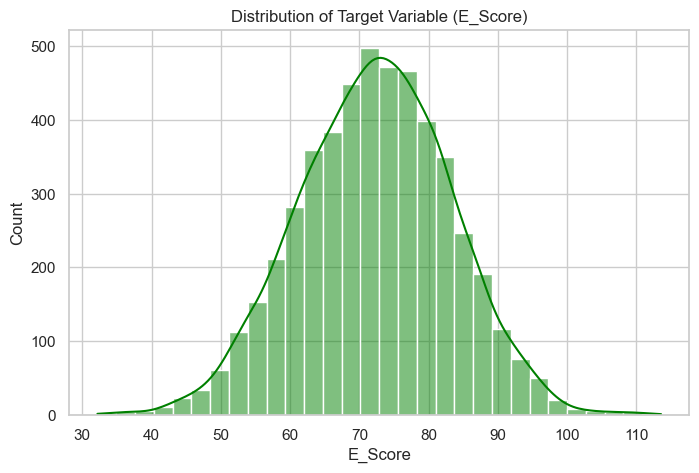

In [40]:
# Distribution of E_Score
plt.figure(figsize=(8, 5))
sns.histplot(df['E_Score'], bins=30, kde=True, color='green')
plt.title('Distribution of Target Variable (E_Score)')
plt.show()

## Model Training (Random Forest)

In [41]:
# Define Features (X) and Target (y)
target = 'E_Score'

In [42]:
# We drop Firm_ID (identifier) and the target itself.
# We KEEP 'ESG_Score', 'S_Score', and 'G_Score' as they are valid inputs per the challenge description.
X = df.drop(columns=[target, 'Firm_ID', 'Calculated_Avg_ESG', 'Diff'])
y = df[target]
groups = df['Firm_ID']

In [43]:
# Preprocessing Pipeline
# - Numeric features: Passed through directly
# - Categorical features (Industry_Type): One-Hot Encoded
categorical_cols = ['Industry_Type']
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [45]:
# Define Model Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [46]:
# Split Data (GroupShuffleSplit prevents data leakage between same firms in train/test)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

In [47]:
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

In [48]:
# Train the model
print("Training Random Forest Model...")
model.fit(X_train, y_train)
print("Training Complete.")

Training Random Forest Model...
Training Complete.


## Evaluation and Feature Importance

In [49]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R2 Score: {r2:.4f}")

Model Performance Results:
Mean Squared Error (MSE): 4.47
R2 Score: 0.9637


## Feature Importance Visualization

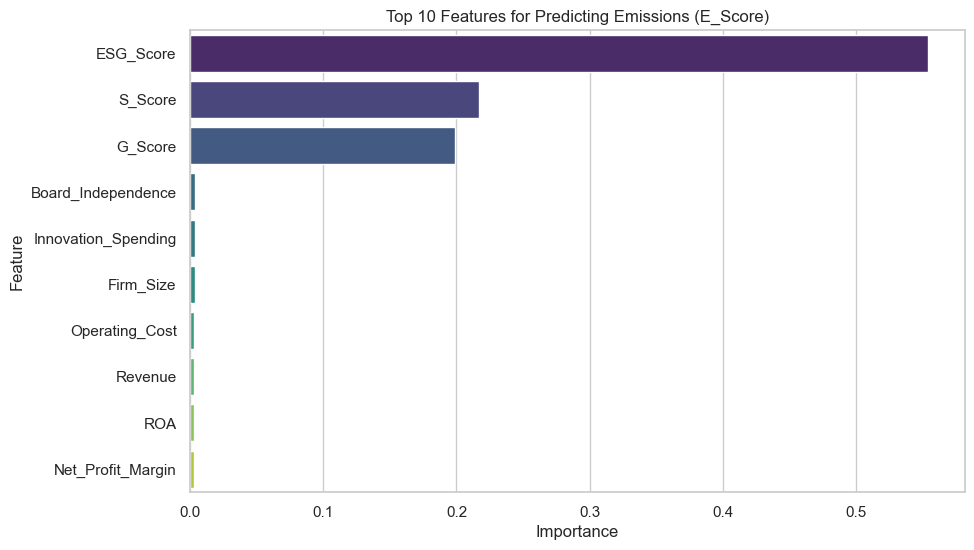

In [50]:
rf_model = model.named_steps['regressor']
cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(cat_feature_names)

importances = rf_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10), palette='viridis')
plt.title('Top 10 Features for Predicting Emissions (E_Score)')
plt.show()

In [51]:
print("Top 5 Drivers of Emissions Score:")
print(feat_imp_df.head(5))

Top 5 Drivers of Emissions Score:
                Feature  Importance
1             ESG_Score    0.553676
2               S_Score    0.216885
3               G_Score    0.198941
10   Board_Independence    0.003558
11  Innovation_Spending    0.003504
